In [40]:
import torch, torchvision
import torch.optim as optim
import torch.nn as nn
import numpy as np
import os
import pandas as pd
from torch.utils.data import DataLoader
#import oil.augLayers as augLayers
from oil.model_trainers.piModel import PiModel
from oil.datasetup.datasets import CIFAR10, C10augLayers
from oil.datasetup.dataloaders import getLabLoader
from oil.architectures.networkparts import layer13,ConvSmallNWN
from oil.utils.utils import cosLr, loader_to, imap,islice
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
from oil.utils.metrics import FID_and_IS

In [43]:
loader_config =     {'amnt_dev':0,'lab_BS':64,'dataseed':0,'num_workers':1}
trainset, testset = CIFAR10(False, '~/datasets/cifar10/',gan_normalize=True)

dataloaders = {}
dataloaders['train'], _ = getLabLoader(trainset,**loader_config)
imgs_only  = imap(lambda z: z[0], dataloaders['train'])
dataloaders['dev'] = loader_to(torch.device('cuda'))(islice(imgs_only,5000//loader_config['lab_BS']))

Files already downloaded and verified
Files already downloaded and verified
Creating Train, Dev split         with 50000 Train and 0 Dev


In [47]:
test,_ = getLabLoader(testset,**loader_config)
test_l = islice(imap(lambda z: z[0].cuda(),test),5000//loader_config['lab_BS'])

Creating Train, Dev split         with 10000 Train and 0 Dev


In [55]:
if torch.zeros(10):
    print("ok")

RuntimeError: bool value of Tensor with more than one value is ambiguous

In [1]:
import dill

In [2]:
def q():
    for i in range(10):
        yield 2*i

In [4]:
dill.dumps(q())

TypeError: can't pickle generator objects

In [49]:

log_dir_base = os.path.expanduser('~/tb-experiments/pi/')
df = pd.read_pickle(log_dir_base +'results.pkl')

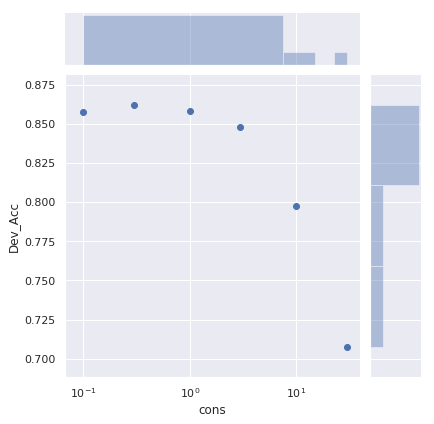

In [37]:
import seaborn as sns
sns.set(style="darkgrid")
g = sns.jointplot('cons','Dev_Acc',data=df)
g.ax_joint.set_xscale('log')

In [52]:
a = (1,2)

In [53]:
a[::-1]

(2, 1)

In [ ]:
## Toy Problem 1 for stochastic eigen decomposition
rank = 10
vec_size = int(1e6)
toy_eigs = (2*torch.rand(rank)-1)
diag_eigs = torch.diag(toy_eigs)
toy_eigVs = torch.ones(rank,1e6).normal_()
toy_eigVs /= toy_eigVs.norm(p=2,dim=1,keepdim=True)

def toy_H_gen(reg=0):
    def H_mb(mbatch, v):
        noise = torch.diag(mbatch)
        return toy_eigVs.t()@(diag_eigs@noise@(toy_eigVs@v)) + reg*v
    curried_H_mb = lambda mbatch: lambda v: H_mb(mbatch, v)
    noise_dataset = torch.normal(mean=torch.ones(1000,rank),std=.005)
    p = toy_eigVs.shape[1]
    rvec = lambda: torch.ones(vec_size).normal_()
    return MatrixLoader(curried_H_mb, noise_dataset,rvec, k=1000)

In [ ]:
## Toy Problem 2 for stochastic eigen decomposition
## PCA
mb = 10000
rank = 10
n = int(1e6)
toy_eigs2 = np.sqrt(.9*np.ones(rank))
toy_eigs2[0] = 1
toy_eigs2 = np.array([1.1,.95,.7,.5,.3,.01,.001,-.4,-.7,-.94])
S = np.diag(toy_eigs2)
#U = torch.ones(rank,1e6).normal_().numpy()
U = np.random.randn(rank,n)
U,_ = np.linalg.qr(U.T)
V = np.random.randn(rank,rank)
V,_ = np.linalg.qr(V.T)
X = np.sqrt(n)*U@S@V.T
def toy_H_gen2(reg=0):
    def H_mb(mbatch, v):
        indices = mbatch; m =len(indices);
        x = X[indices]
        return  (1/m)*x.T@(x@v)+ reg*v
    curried_H_mb = lambda mbatch: lambda v: H_mb(mbatch, v)
    index_dataset = np.random.permutation(n).reshape(n//mb,mb)
    rvec = lambda: np.random.randn(rank)
    return MatrixLoader(curried_H_mb, index_dataset, rvec, k=n//mb)

In [ ]:
index = toy_eigs2.argmax()
v = V.T[index]

In [ ]:
# index = toy_eigs.argmax()
# v = toy_eigVs[index]

In [ ]:
def grad_norm(w):
    Aw = cov@w
    grad = Aw - (w@Aw)*w
    return np.linalg.norm(grad)

In [ ]:
num_epochs = 5
lr = lambda e: 5e-1#*cosLr(num_epochs)(e)
#lr = lambda e:[4e-1,4e-2,4e-3][e]#

In [ ]:
sins = []
lrs = []
grad_norms = []
ws = []
sin_pair = lambda u, w: 1-(v@w)**2 /((w@w)*(u@u))
sin2 = lambda w: sin_pair(v,w)
def mean(total, elem):
    w0,n = total
    w_avg,_ = elem
    print(w0)
    w_avg = w0*n/(n+1) + w_avg/(n+1)
    new_total = w_avg,n+1
    return new_total
    
log = lambda _,w,lrr: (sins.append(sin2(w)),grad_norms.append(grad_norm(w)),
                       lrs.append(lrr),ws.append(w))

In [ ]:
W = ojas_top_eig3(toy_H_gen2, lr,num_epochs, log)

In [ ]:
w_avgs = list(starmap(lambda a,b: b/a, enumerate(accumulate(ws[int(len(sins)/10):]), 1)))
avg_sins = [sin2(w) for w in w_avgs]
plt.plot(sins)
plt.plot(lrs)
plt.plot(grad_norms)
plt.plot(np.arange(len(sins))[-len(avg_sins):], np.array(avg_sins))
plt.yscale('log')
#plt.xscale('log')
plt.legend(["Sin^2 Error", "lr","Grad norm","Avg_Sin^2"])

In [ ]:
cov = X.T@X/n
a,b = np.linalg.eigh(cov)

In [ ]:
r = lambda v: v@cov@v / (v@v)

In [ ]:
print(r(w))
print(r(v))
print(r(b.T[-1]))
print(r(b.T[0]))

In [ ]:
a

In [ ]:
from oil.extra.mvm import detached_entropy
import torch.nn.functional as F

In [ ]:
logits = 4*torch.ones(10).normal_()

In [ ]:
logits.requires_grad = True

In [ ]:
batch_logits = logits.unsqueeze(0)*torch.ones(10).unsqueeze(1)

In [ ]:
batch_logits[0]

In [ ]:
e = detached_entropy(batch_logits, 0)

In [ ]:
i = 1

In [ ]:
e1 = torch.zeros(10); e1[i]=1

In [ ]:
g = flatten(torch.autograd.grad(e,[logits],create_graph=True))

In [ ]:
e1@flatten(torch.autograd.grad(e1@g,[logits]))

In [ ]:
s = F.softmax(batch_logits,dim=1).detach()[0]

In [ ]:
s[i]*(i==j)-s[i]*s[j]

In [ ]:
l = lambda *args,**kwargs:None

In [ ]:
l(3,2)

In [ ]:
l(3,k=1)

In [ ]:
from ipywidgets import interact

In [ ]:
interact(lambda x:x, x=True)

In [ ]:
from oil.utils import cur

In [ ]:
def f(x,y,z=True):
    return (x+y)*z

In [ ]:
cur(f,minArgs=-1)(3)

In [ ]:
def gen():
    for i in range(10):
        yield 2*i

In [ ]:
iter(gen())

In [ ]:
import inspect

In [ ]:
dir(f)

In [ ]:
dir(inspect.getfullargspec(f))

In [ ]:
inspect.getfullargspec(lambda:0).args

In [ ]:
%timeit sum(range(1000000))

In [ ]:
%timeit sum(range(100000))

In [ ]:
%timeit sum([x for x in range(1000000)])

In [ ]:
%timeit np.arange(1000000).sum()

In [ ]:
%timeit sum(map(lambda x:x,range(1000000)))

In [ ]:
%timeit [x for x in range(1000000)]

In [ ]:
def mysum(iterable):
    s = 0
    for i in iterable:
        s+=i
    return s

In [ ]:
%timeit mysum(range(1000000))

In [ ]:
import inspect
import copy,dill

In [ ]:
def frame():
    frame = inspect.currentframe()
    outer_frames = inspect.getouterframes(frame)
    return outer_frames

In [ ]:
def dillcopy(obj):
    return dill.loads(dill.dumps(obj))

In [ ]:
def reconstructor():
    frame = inspect.currentframe()
    outer_frames = inspect.getouterframes(frame)
    subclass_depth=-1
    while inspect.getframeinfo(outer_frames[subclass_depth+2][0])[2]=='__init__':
        subclass_caller_frame = outer_frames[subclass_depth+2][0]
        subclass_depth +=1
        
    assert subclass_depth >=0, "Not called in an __init_ method_"
    print("subclass depth = {}".format(subclass_depth))
    argnames,varargname,keywordname,localss = inspect.getargvalues(subclass_caller_frame)
    args_in = {k:v for k,v in localss.items() if k in argnames}
    cls = args_in.pop("self").__class__
    args_in_copy = dillcopy(args_in)
    
    args = dillcopy(localss[varargname]) if varargname is not None else None
    kwargs = dillcopy(localss[keywordname]) if keywordname is not None else None
    if kwargs is not None: kwargs.update(args_in_copy)
    else: kwargs = args_in_copy
    
    if args is not None: return lambda: cls(*args,**kwargs)
    else: return lambda: cls(**kwargs)

In [ ]:
class A:
    def __init__(self,b,c=3,einit=lambda:None):
        self.b=b
        self.c=c
        einit()
        self.r = reconstructor()
        #self.f = frame()

In [ ]:
class B(A):
    def __init__(self,*args,d=5,**kwargs):
        def einit():
            self.d=d
        super().__init__(*args,einit=einit,**kwargs)

In [ ]:
b = B(4,c=2)

In [ ]:
b1 = b.r()

In [ ]:
for attr, value in b1.__dict__.items():
    print((attr, value))
for attr, value in b.__dict__.items():
    print((attr, value))

In [ ]:
from oil.utils import full_load
import torch

In [ ]:
trainer = full_load('/home/maf388/tb-experiments/layer13half/checkpoints/c.2.ckpt')

In [ ]:
s = torch.load('/home/maf388/tb-experiments/layer13half/checkpoints/c.2.ckpt', pickle_module=dill)

In [ ]:
import torch.optim as optim

In [ ]:
t = s['reconstructor']

In [ ]:
t(z=3,k=4)

In [ ]:
d = {'l':3}

In [ ]:
v = lambda **stuff:d.update(stuff)

In [ ]:
v(k=2)

In [ ]:
d

In [ ]:
d.update({})

In [ ]:
v(**dict(d,**{'k':3}))

In [ ]:
d

In [ ]:
v(**dict)

In [ ]:
dict(d,**{'k':5})

In [ ]:
import numpy as np

In [ ]:
from math import ceil,sqrt

In [ ]:
def generator():
    i = 1
    while True:
        yield i
        i += 1

In [ ]:
from itertools import islice
 
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))
 
print(take(5, generator()))
# [1, 2, 3, 4, 5]

In [ ]:
def primes():
    for n in generator():
        if not any(i > 1 and n%i == 0
                   for i in islice(generator(), ceil(sqrt(n)))):
            yield n

In [ ]:
def primes2():
    ps = []
    for n in generator():
        if not any(takewhile(lambda p: p < sqrt(n), i > 1 and n%i == 0 for i in ps)):
            ps+=[n]
            yield n

In [ ]:
%timeit take(5000, primes())

In [ ]:
%timeit take(5000, primes2())

In [ ]:
class A:
    def __init__(self):
        self.q =2

In [ ]:
a = A()

In [ ]:
for a.q in range(a.q,10):
    print(a.q)

In [ ]:
a.q

In [ ]:
try: import kksda; x=3
except ModuleNotFoundError: pass

In [ ]:
x

In [ ]:
class B(object):
    def __init__(self):
        pass

In [ ]:
b = B()

In [ ]:
b.a()

In [ ]:
from collections import Callable


In [ ]:
class F(object):
    def __getattribute__(self,name):
        return (lambda *args, **kwargs:None)

In [ ]:
e = F()

In [ ]:
e.e()

In [ ]:
class Silent(object):
    def bbb(self):
        print("load")
    def __getattr__(self, name):
        if not hasattr(Silent, name):
            return (lambda *args, **kwargs:None)
        #else:
        #    return object.__getattr__(self,name)

In [ ]:
s = Silent()

In [ ]:
s.s=3

In [ ]:
s.s

In [ ]:
s.bbb()

In [ ]:
class Q(Silent):
    def aaa(self):
        print("louder")

In [ ]:
q = Q()

In [ ]:
q.aaa()

In [ ]:
from tensorboardX import SummaryWriter

In [ ]:
s = SummaryWriter(None)

In [ ]:
s.add_scalar("a",3)

In [ ]:
print(s)

In [ ]:
s.add_scalar

In [ ]:
import pandas as pd

In [ ]:
h = {'descr':"The grey fox ambled along the river bank"}

In [ ]:
d = {'a':3}

In [ ]:
row = pd.DataFrame(d, index=[0])

In [ ]:
row = row.append(pd.DataFrame({'a':2,'b':2},index=[1]))

In [ ]:
d['h']

In [ ]:
row.ewm(com=5).mean()

In [ ]:
row.index

In [ ]:
import pandas as pd
a = pd.DataFrame({'k':3,'v':2},index=[0])
b = a.combine_first(pd.DataFrame({'k':4,'v':4},index=[1]))
c = b.ewm(com=2).mean().iloc[-1:]
print(c)

In [ ]:
c.to_frame().T

In [ ]:
print(repr(b))

In [ ]:
s.add('c')

In [ ]:
s

In [ ]:
a = {}

In [ ]:
try: a['tag'].add('b')
except KeyError: a['tag'] = {'b'}

In [ ]:
a

In [ ]:
a.items()

In [ ]:
a.__repr__()

In [ ]:
l = LazyLogger()

In [ ]:
l.add_scalars("Metrics",{'Loss':3},)

In [ ]:
print(l)

In [ ]:
def func(x):
    v =3
    x()

In [ ]:
def q():
    global v
    print(v)

In [ ]:
func(q)

In [ ]:
s = {'a':3,'b':5}

In [ ]:
print(s)

In [ ]:
prettyPrintDict(s)

In [ ]:
import tqdm

In [ ]:
import inspect
try: 
    from tqdm import tqdm
    old_print = print
    def new_print(*args, **kwargs):
        # if tqdm.tqdm.write raises error, use builtin print
        try: tqdm.write(*map(lambda x: str(x),args), **kwargs)
        except: 
            old_print("failure")
            old_print(*args, ** kwargs)
    inspect.builtins.print = new_print
except ImportError:
    tqdm = lambda it:it
for i,j in enumerate(tqdm(range(1000000))):
    if i%100000==0: tqdm.write((1,2))

In [ ]:
from tqdm import tqdm
for i,j in enumerate(tqdm(range(1000000))):
    if i%100000==0: tqdm.write((1,2))

In [ ]:
def showargs(*args):
    print(type(args[0]))

In [ ]:
def test(*args):
    showargs(*map(lambda x: str(x),args))

In [ ]:
test((1,2))

In [ ]:
print("hello")

In [ ]:
!gpustat

In [ ]:
class A:
    def p(self):
        print("Ap")

In [ ]:
class B(A):
    def p(self, arg):
        print(arg)
        print("Bp")
        super().p()

In [ ]:
class C(B):
    pass

In [ ]:
class D(C):
    pass

In [ ]:
d = D()

In [ ]:
d.p(1)

In [ ]:
import numpy as np

In [ ]:
np.arange(10)[:-1]

In [ ]:
#s = "transpose"

class A(object):
    def __init__(self):
        pass
#         print("did this")
#         module = __import__('numpy')
#         my_class = getattr(module, 'zeros')
#         print(my_class(1))
    def t(self):
        print(s)

In [ ]:
b = A()

In [ ]:
s = 5

In [ ]:
b.t()

In [ ]:
b.T

In [ ]:
@property
def T(self):
    return self if len(self.shape)==1 else self.t()

In [ ]:
A.T = T

In [ ]:
b

In [ ]:
b.T

In [ ]:
import torch

In [ ]:
torch.Tensor.T = T

In [ ]:
x= torch.ones(10)

In [ ]:
len(x.shape)

In [ ]:
x.T

In [ ]:
import numpy as np
a = np.ones(10)

In [ ]:
len(a.shape)

In [ ]:
d = {1:2,3:4}

In [ ]:
d.keys()

In [ ]:
d.items()

In [ ]:
d.values()

In [ ]:
v = d.update({5:6})

In [ ]:
d = {1:1}

In [ ]:
v = {2:2}

In [ ]:
q = zip(d,v)

In [ ]:
for a in q:
    print(a)

In [ ]:
class B():
    var = 1
    def change_var():
        B.var +=1
        print("changed")

In [ ]:
b = B()

In [ ]:
B.change_var()

In [ ]:
B.var

In [ ]:
b.var

In [ ]:
torch.new((10))